# Model V2 (Smaller Unit) 

One of the major feedback I received was that the architecture unit is likely too large. In this variation, I'll test using a smaller unit size. 

In [49]:

%reload_ext autoreload


In [50]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.style.use('fivethirtyeight')
%matplotlib inline

from tensorflow.keras.applications import NASNetLarge 
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, model_from_json, load_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import pickle
import os
from timeit import default_timer as timer

import string
import re

Loading custom scripts

In [51]:
from SCRIPT.sequence_generator import *
from SCRIPT.evaluation_tools import *

File locations

In [59]:
flicker_img_dir = 'IMAGES/Flicker/Flicker8k_Dataset'
flicker_text_dir = 'IMAGES/Flicker/labels'
img_dir = 'IMAGES\paintings'

## Feature Extraction
Extract features using NASNetLarge

In [5]:
def feature_extractor(dir_, network):
    ''' 
    iterate through files in dir_ 
    and get features running on network
    return a dictionary with image id as a key
    '''
    model = network()
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    fnames = [x for x in os.listdir(dir_) if x.endswith('.jpg')]
    result = {}
    i = 1
    n = len(fnames)
    
    for fn in fnames:
        img = load_img(f'{dir_}/{fn}', target_size = (331, 331))
        img = np.expand_dims(img, 0)
        img = preprocess_input(img)
        feature = model.predict(img)
        ind = fn.split('.')[0]
        result[ind] = feature
        print(f'{i}/{n} feature extraction completed')
        i += 1
    return result

In [ ]:
# run
features = feature_extractor(flicker_img_dir, NASNetLarge)

In [ ]:
# Saving
#with open('PKL/features.pkl', 'wb') as fp:
#    pickle.dump(features, fp, pickle.HIGHEST_PROTOCOL)

In [7]:
# loading
with open('PKL/features.pkl', 'rb') as fp:
    features = pickle.load(fp)

extract feature from paintings too

In [ ]:
art_features = feature_extractor(img_dir, NASNetLarge)

In [ ]:
# saving the extracted features
#with open('PKL/art_features.pkl', 'wb') as fp:
#    pickle.dump(art_features, fp, pickle.HIGHEST_PROTOCOL)

In [60]:
# loading
with open('PKL/art_features.pkl', 'rb') as fp:
    art_features = pickle.load(fp)

## Get Descriptions

In [10]:
# read the description file
with open(f'{flicker_text_dir}/Flickr8k.token.txt', 'r') as fn:
    text = fn.readlines()

In [11]:
# extract only image id and description
pattern = '([0-9a-z_]*)\.jpg.*\\t(.*)\\n'
p = re.compile(pattern)
descriptions_pairs = [p.findall(x)[0] for x in text]

In [12]:
def description_preprocessing(list_of_tuples, n = None):
    '''
    given description pairs, return a dictionary of descriptions
    if n is specified, only select the n number or less descriptions
    per image
    '''
    descriptions = {}

    table_ = str.maketrans('', '', string.punctuation+string.digits)

    for ind, text in list_of_tuples:
        text = text.lower()
        text = str.translate(text, table_)
        text = [x for x in text.split() if len(x) > 1] # remove trailing alphabet
        text = 'seqini ' + ' '.join(text) + ' seqfin' # add initial and ending tokens
        if ind in descriptions:
            descriptions[ind].append(text)
        else:
            descriptions[ind] = [text]
    if n:
        # if n is assigned cap number of description for each image to be n
        for k, v in descriptions.items():
            if len(v) > n:
                descriptions[k] = list(np.random.choice(v, n, replace = False))
    return descriptions

In [13]:
# saving
#with open('PKL/descriptions.pkl', 'wb') as fp:
#    pickle.dump(descriptions, fp)

# loading
with open('PKL/descriptions.pkl', 'rb') as fp:
    descriptions = pickle.load(fp)

In [69]:
with open('PKL/img_captions1.pkl', 'rb') as fp:
    img_caption1 = pickle.load(fp)

In [70]:
# remove trailing one characters
img_caption = [(k, v) for k, v in img_caption1.items() if v and (len(v) > 1)]
img_ids = [x[0] for x in img_caption]

## Crossvalidation
Split the photo sets into train/test/val

In [14]:
train_list, test_list = train_test_split(list(descriptions.keys()), test_size = 0.3, random_state = 22)
val_list, test_list = train_test_split(test_list, test_size = 0.5, random_state = 22)

## Model Training
Train model with photo files

In [15]:
# initialize processor with non-art descriptions and features
processor = sequence_generator(descriptions, features)

In [16]:
# get inputs and output
train_X1, train_X2, train_Y = processor.train_generator(train_list)
val_X1, val_X2, val_Y = processor.validation_generator(val_list)

In [17]:
# get max length and number of vocabularies
max_length = processor.get_max_length()
num_vocab = processor.get_num_vocab()

In [18]:
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(64, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 256, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(64)(text_layer2)
# outputting
output_layer1 = add([img_layer2, text_layer3])
output_layer2 = Dense(64, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

cp = EarlyStopping(patience = 3, restore_best_weights= True)

# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=10, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/10
9046/9046 [==============================] - 385s 43ms/step - loss: 4.5275 - val_loss: 3.9860
Epoch 2/10
9046/9046 [==============================] - 381s 42ms/step - loss: 3.8176 - val_loss: 3.8378
Epoch 3/10
9046/9046 [==============================] - 384s 42ms/step - loss: 3.5958 - val_loss: 3.8111
Epoch 4/10
9046/9046 [==============================] - 382s 42ms/step - loss: 3.4856 - val_loss: 3.8175
Epoch 5/10
9046/9046 [==============================] - 395s 44ms/step - loss: 3.4175 - val_loss: 3.8240
Epoch 6/10
9046/9046 [==============================] - 402s 44ms/step - loss: 3.3746 - val_loss: 3.8439
Total Time Elapsed:  38  minutes  57  seconds


In [19]:
# saving model
model.save('MODEL/small_model_1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: MODEL/small_model_1\assets


In [ ]:
#loading model
model = load_model('MODEL/small_model')

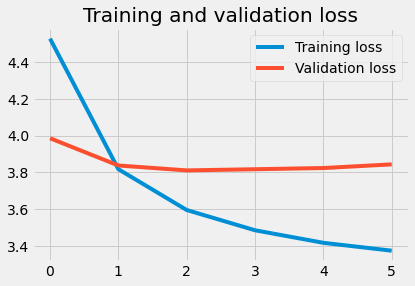

In [20]:
plot_performance(history)

In [21]:
# get the tokenizer
tokenizer = processor.get_tokenizer()

In [ ]:
# testing on photo data
pred_list, score = get_bleu(test_list, features, tokenizer, max_length, model, descriptions)

1-gram BLEU: 0.4223
2-gram BLEU: 0.2288
3-gram BLEU: 0.1477
4-gram BLEU: 0.0604

In [61]:
photo_descriptor = descriptor(features, tokenizer, processor, model, flicker_img_dir)
art_descriptor = descriptor(art_features, tokenizer, processor, model, img_dir)

two dogs are playing in the snow


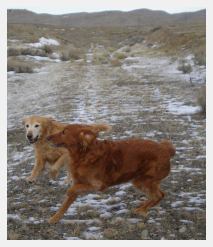

In [67]:
photo_descriptor.test_random_image(test_list)

man in red shirt is standing on the street


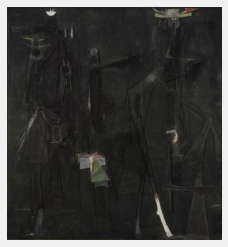

In [74]:
art_descriptor.test_random_image(img_ids)

### deeper model

In [86]:
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(64, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 256, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(64, return_sequences = True)(text_layer2)
text_layer4 = Dropout(0.5)(text_layer3)
text_layer5 = LSTM(64, return_sequences = True)(text_layer4)
text_layer6 = Dropout(0.5)(text_layer5)
text_layer7 = LSTM(64)(text_layer6)
# outputting
output_layer1 = add([img_layer2, text_layer7])
output_layer2 = Dense(64, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

#cp = EarlyStopping(patience = 3, restore_best_weights= True)

# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=50, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = -1,  
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/50
9046/9046 [==============================] - 796s 88ms/step - loss: 4.7943 - val_loss: 4.2739
Epoch 2/50
9046/9046 [==============================] - 786s 87ms/step - loss: 4.1205 - val_loss: 4.0924
Epoch 3/50
9046/9046 [==============================] - 793s 88ms/step - loss: 3.9008 - val_loss: 4.0524
Epoch 4/50
9046/9046 [==============================] - 799s 88ms/step - loss: 3.7978 - val_loss: 4.0349
Epoch 5/50
9046/9046 [==============================] - 791s 87ms/step - loss: 3.7381 - val_loss: 4.0250
Epoch 6/50
9046/9046 [==============================] - 785s 87ms/step - loss: 3.7019 - val_loss: 4.0119
Epoch 7/50
9046/9046 [==============================] - 785s 87ms/step - loss: 3.6742 - val_loss: 4.0330
Epoch 8/50
9046/9046 [==============================] - 781s 86ms/step - loss: 3.6603 - val_loss: 4.0347
Epoch 9/50
9046/9046 [==============================] - 34311s 4s/step - loss: 3.6456 - val_loss: 4.0611
Epoch 10/50
9046/9046 [==============================] 

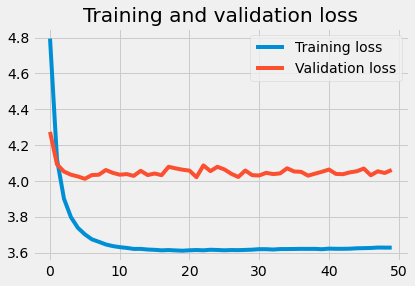

In [87]:
plot_performance(history)

In [88]:
# saving model
model.save('MODEL/small_model_2')

INFO:tensorflow:Assets written to: MODEL/small_model_2\assets


In [89]:
# testing on photo data
pred_list2, score2 = get_bleu(test_list, features, tokenizer, max_length, model, descriptions)

1 / 1214 complete
2 / 1214 complete
3 / 1214 complete
4 / 1214 complete
5 / 1214 complete
6 / 1214 complete
7 / 1214 complete
8 / 1214 complete
9 / 1214 complete
10 / 1214 complete
11 / 1214 complete
12 / 1214 complete
13 / 1214 complete
14 / 1214 complete
15 / 1214 complete
16 / 1214 complete
17 / 1214 complete
18 / 1214 complete
19 / 1214 complete
20 / 1214 complete
21 / 1214 complete
22 / 1214 complete
23 / 1214 complete
24 / 1214 complete
25 / 1214 complete
26 / 1214 complete
27 / 1214 complete
28 / 1214 complete
29 / 1214 complete
30 / 1214 complete
31 / 1214 complete
32 / 1214 complete
33 / 1214 complete
34 / 1214 complete
35 / 1214 complete
36 / 1214 complete
37 / 1214 complete
38 / 1214 complete
39 / 1214 complete
40 / 1214 complete
41 / 1214 complete
42 / 1214 complete
43 / 1214 complete
44 / 1214 complete
45 / 1214 complete
46 / 1214 complete
47 / 1214 complete
48 / 1214 complete
49 / 1214 complete
50 / 1214 complete
51 / 1214 complete
52 / 1214 complete
53 / 1214 complete
54

417 / 1214 complete
418 / 1214 complete
419 / 1214 complete
420 / 1214 complete
421 / 1214 complete
422 / 1214 complete
423 / 1214 complete
424 / 1214 complete
425 / 1214 complete
426 / 1214 complete
427 / 1214 complete
428 / 1214 complete
429 / 1214 complete
430 / 1214 complete
431 / 1214 complete
432 / 1214 complete
433 / 1214 complete
434 / 1214 complete
435 / 1214 complete
436 / 1214 complete
437 / 1214 complete
438 / 1214 complete
439 / 1214 complete
440 / 1214 complete
441 / 1214 complete
442 / 1214 complete
443 / 1214 complete
444 / 1214 complete
445 / 1214 complete
446 / 1214 complete
447 / 1214 complete
448 / 1214 complete
449 / 1214 complete
450 / 1214 complete
451 / 1214 complete
452 / 1214 complete
453 / 1214 complete
454 / 1214 complete
455 / 1214 complete
456 / 1214 complete
457 / 1214 complete
458 / 1214 complete
459 / 1214 complete
460 / 1214 complete
461 / 1214 complete
462 / 1214 complete
463 / 1214 complete
464 / 1214 complete
465 / 1214 complete
466 / 1214 complete


827 / 1214 complete
828 / 1214 complete
829 / 1214 complete
830 / 1214 complete
831 / 1214 complete
832 / 1214 complete
833 / 1214 complete
834 / 1214 complete
835 / 1214 complete
836 / 1214 complete
837 / 1214 complete
838 / 1214 complete
839 / 1214 complete
840 / 1214 complete
841 / 1214 complete
842 / 1214 complete
843 / 1214 complete
844 / 1214 complete
845 / 1214 complete
846 / 1214 complete
847 / 1214 complete
848 / 1214 complete
849 / 1214 complete
850 / 1214 complete
851 / 1214 complete
852 / 1214 complete
853 / 1214 complete
854 / 1214 complete
855 / 1214 complete
856 / 1214 complete
857 / 1214 complete
858 / 1214 complete
859 / 1214 complete
860 / 1214 complete
861 / 1214 complete
862 / 1214 complete
863 / 1214 complete
864 / 1214 complete
865 / 1214 complete
866 / 1214 complete
867 / 1214 complete
868 / 1214 complete
869 / 1214 complete
870 / 1214 complete
871 / 1214 complete
872 / 1214 complete
873 / 1214 complete
874 / 1214 complete
875 / 1214 complete
876 / 1214 complete


1-gram BLEU: 0.4388
2-gram BLEU: 0.2505
3-gram BLEU: 0.1679
4-gram BLEU: 0.0756

In [90]:
photo_descriptor = descriptor(features, tokenizer, processor, model, flicker_img_dir)
art_descriptor = descriptor(art_features, tokenizer, processor, model, img_dir)

man is climbing rock rock


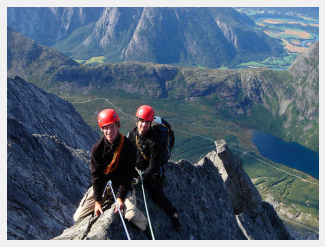

In [91]:
photo_descriptor.test_random_image(test_list)

man in red shirt is jumping off of trampoline


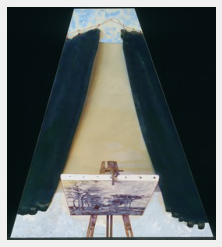

In [92]:
art_descriptor.test_random_image(img_ids)